<a href="https://colab.research.google.com/github/HagarTibi/Image-Restoration-with-Diffusion-Model-24-2-R-5/blob/main/diffCOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Update project path to the exact location of your main project files
project_path = '/content/drive/MyDrive/CamoDiffusion-main/'

# Navigate to the project folder
os.chdir(project_path)

# Verify the current working directory
print("Current Directory:", os.getcwd())


Current Directory: /content/drive/.shortcut-targets-by-id/1gO6o32tK2__6XSiKExiXFUmo_Q0EpQ-O/CamoDiffusion-main


2. Requirments Installation

In [3]:
!pip install -r requirements.txt --verbose


Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Obtaining dependency information for accelerate==0.17.1 from https://files.pythonhosted.org/packages/0a/ca/96a50d122bd07d06c66e20e6bd275b5c8829602398f4e141f8755a25e31e/accelerate-0.17.1-py3-none-any.whl.metadata
  Obtaining dependency information for albumentations==1.3.0 from https://files.pythonhosted.org/packages/4f/55/3c2ce84c108fc1d422afd6de153e4b0a3e6f96ecec4cb9afcf0284ce3538/albumentations-1.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for einops==0.6.0 from https://files.pythonhosted.org/packages/4b/f7/8557c683501eb14462b60e32d21fc51317ab2ba39688db1b8b7cebe1a274/einops-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib==3.6.2 from https://files.pythonhosted.org/packages/83/71/5ff2ef1ddb8e12cf50b741d68de649731684779ab9cc7f5d15bbf335481a/matplotlib-3.6.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Link requires a different 

3. Training The Model

In [ ]:
!accelerate launch --num_processes=1 --num_machines=1 --mixed_precision=no --dynamo_backend=no \
    /content/drive/MyDrive/CamoDiffusion-main/train.py \
    --config /content/drive/MyDrive/CamoDiffusion-main/config/camoDiffusion_352x352.yaml \
    --num_epoch=5 --batch_size=16 --gradient_accumulate_every=1


CUDA Available: True

train_dataset:
	name:		dataset.data_val.PolypObjDataset
	params:
		image_root:			/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_Imgs/
		gt_root:			/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_GT/
		trainsize:			352
		boundary_modification:			True
test_dataset:
	BrainMRI:
		name:			dataset.data_val.test_dataset
		params:
			image_root:				/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_Imgs/
			gt_root:				/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT/
			testsize:				352
project_name:	CamoDiffusion
__base__:	[]
model:
	name:		model.net.net
	params:
		class_num:			1
		mask_chans:			1
cond_uvit:
	name:		model.net.EmptyObject
	params:
		conditioning_klass:			model.net.EmptyObject
diffusion_model:
	name:		model.SimpleDiffSef.CondGaussianDiffusion
	params:
		model:			None
		image_size:			352
		channels:			1
		cond_channels:			3
		noise_d:			64
		num_sample_steps:			10
		clip_sample_denoised:

4. Sample Test

In [10]:
# @title
!accelerate launch --num_processes=1 --num_machines=1 --mixed_precision=no --dynamo_backend=no \
    /content/drive/MyDrive/CamoDiffusion-main/sample.py \
    --config /content/drive/MyDrive/CamoDiffusion-main/config/camoDiffusion_384x384.yaml \
    --results_folder /content/drive/MyDrive/CamoDiffusion-main/results/ \
    --checkpoint /content/wandb/latest-run/model-best.pt \
    --num_sample_steps 10 \
    --target_dataset BrainMRI \
    --time_ensemble


/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
100% 51/51 [03:42<00:00,  4.36s/it]
BrainMRI mae: 0.015313955446610707
100% 404/404 [00:21<00:00, 18.64it/s] 
BrainMRI : Test Complete!


5. Results - Metrics & Visualization

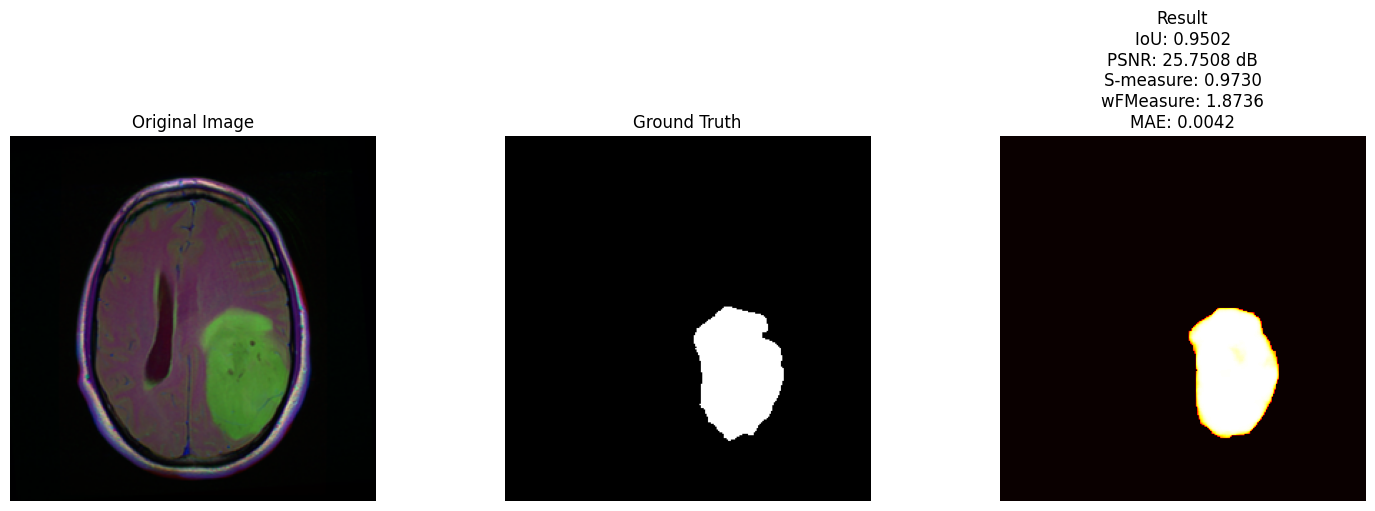

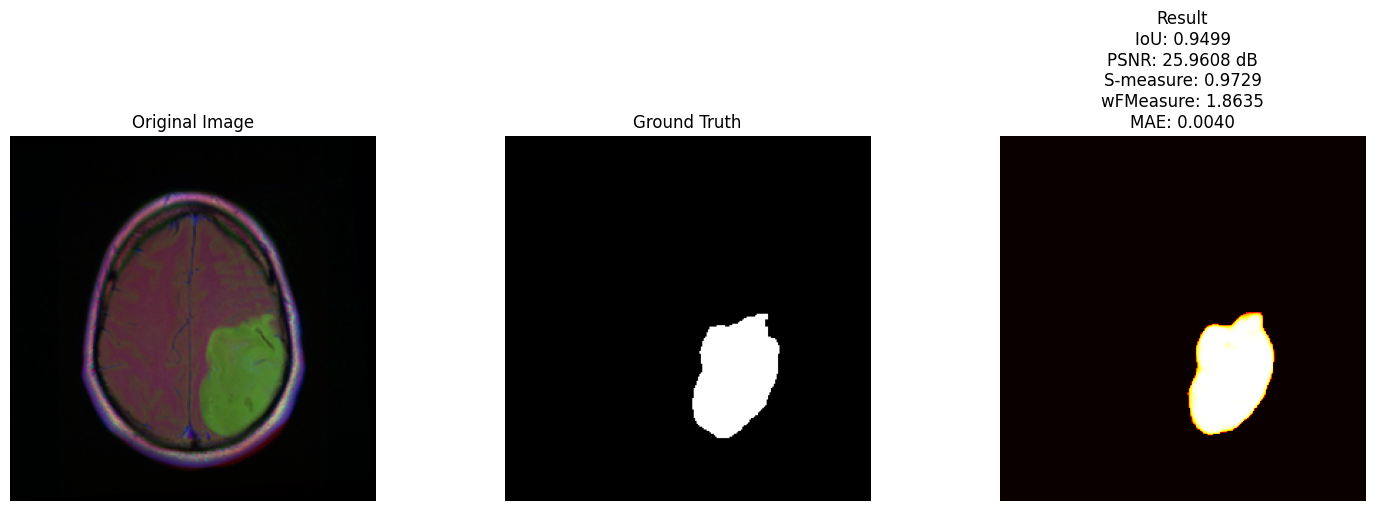

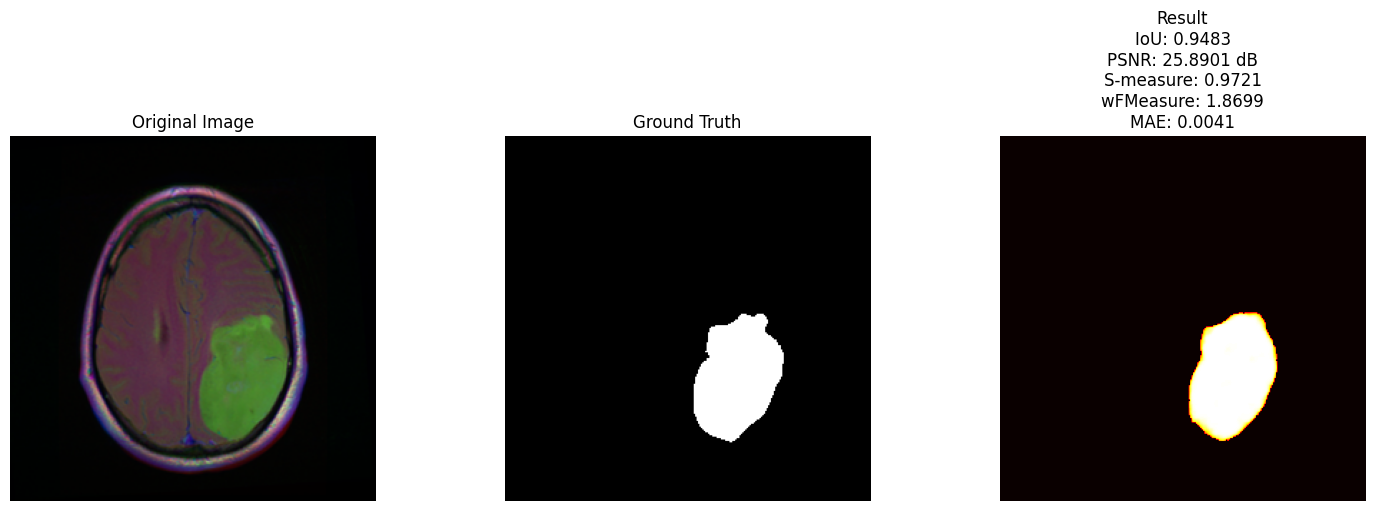

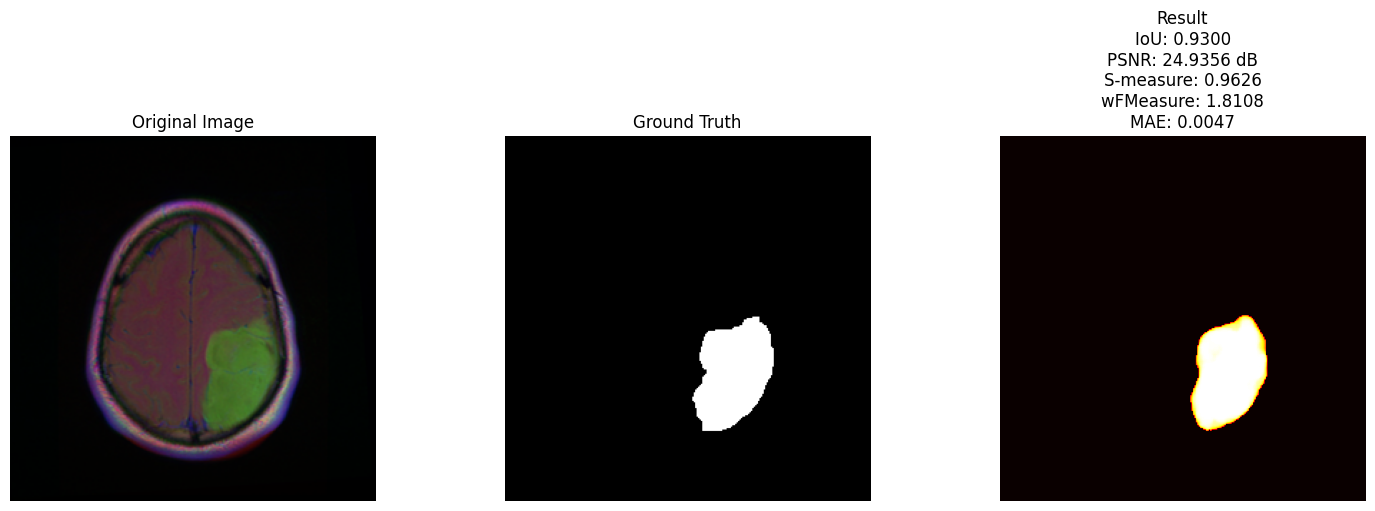

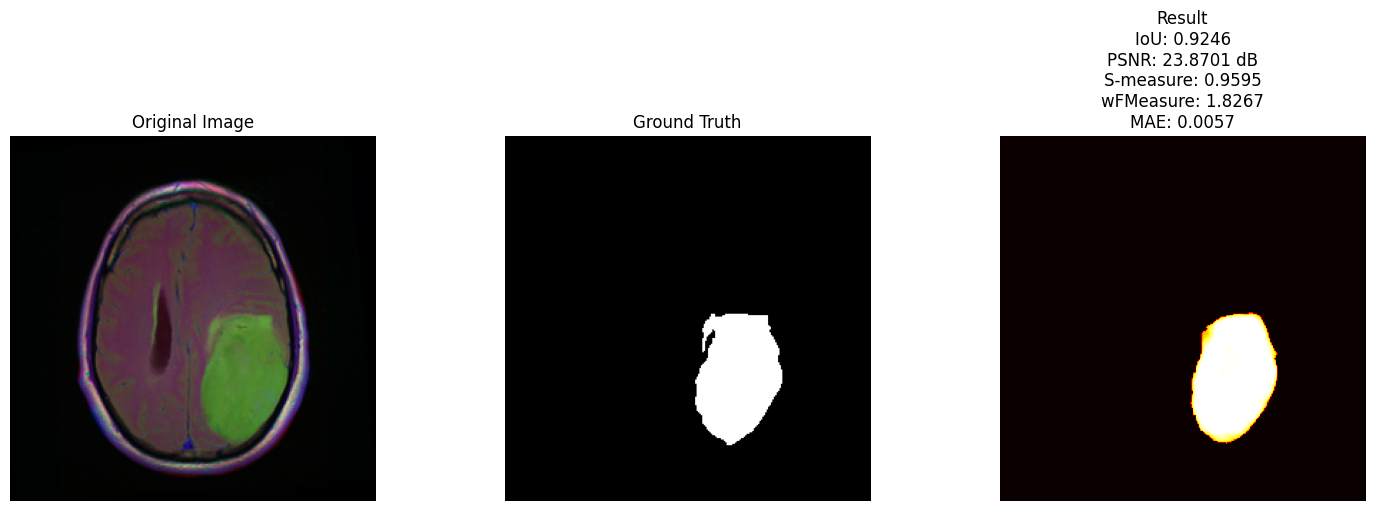

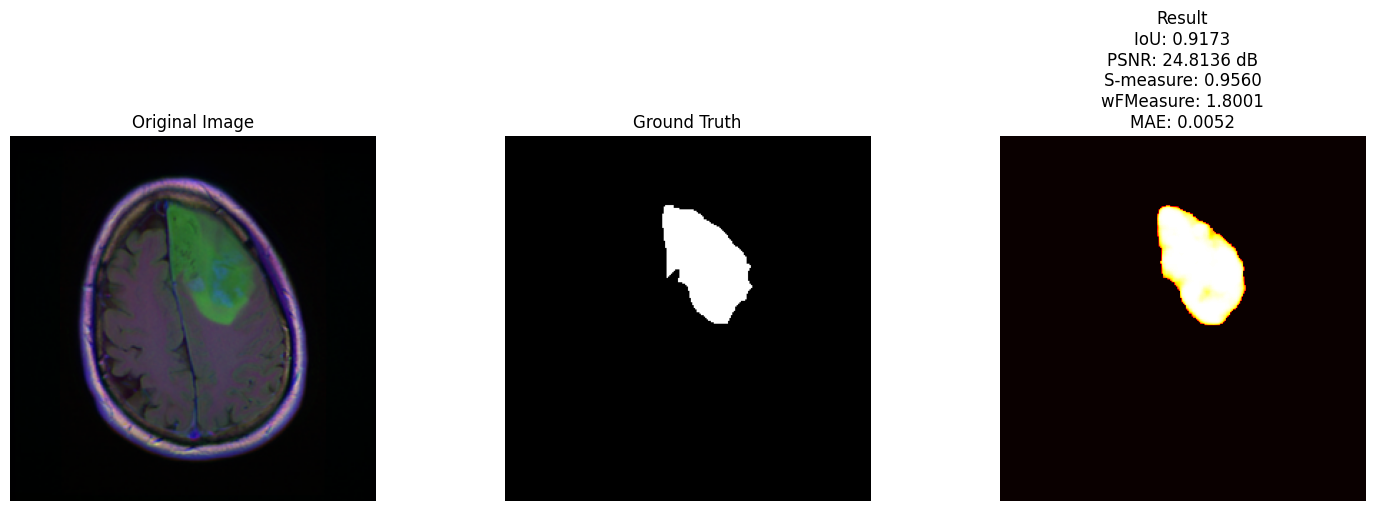

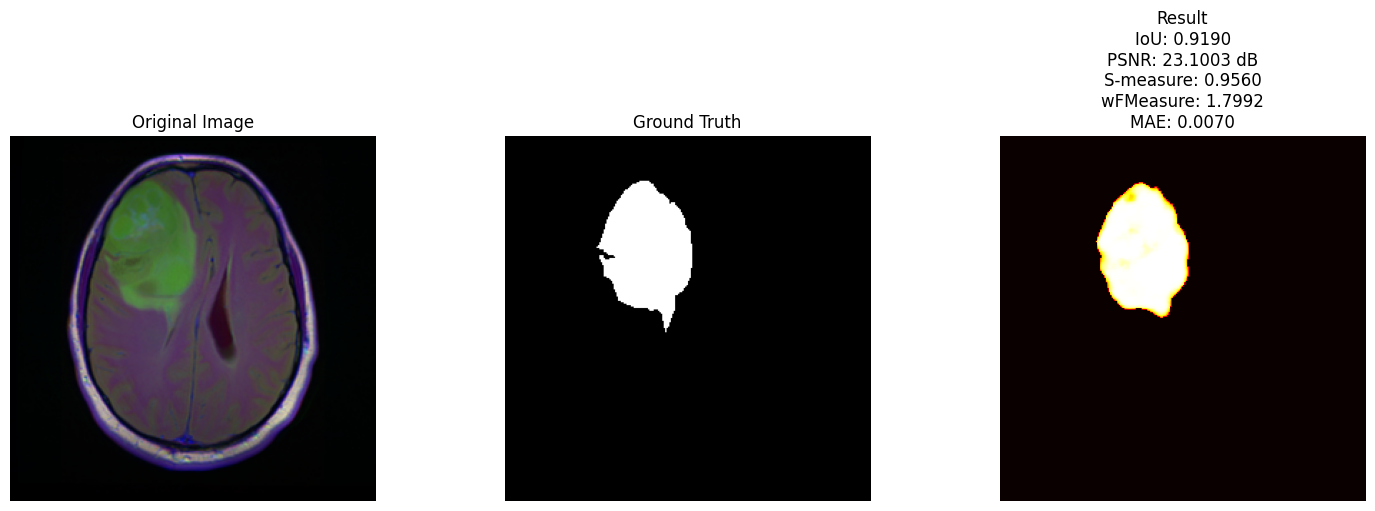

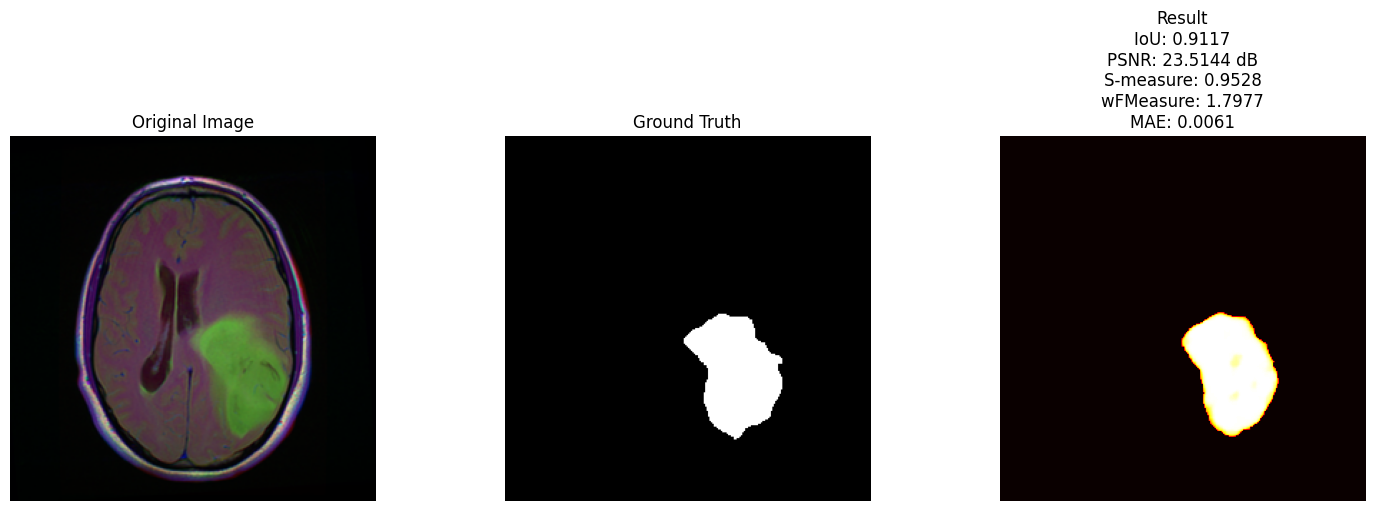

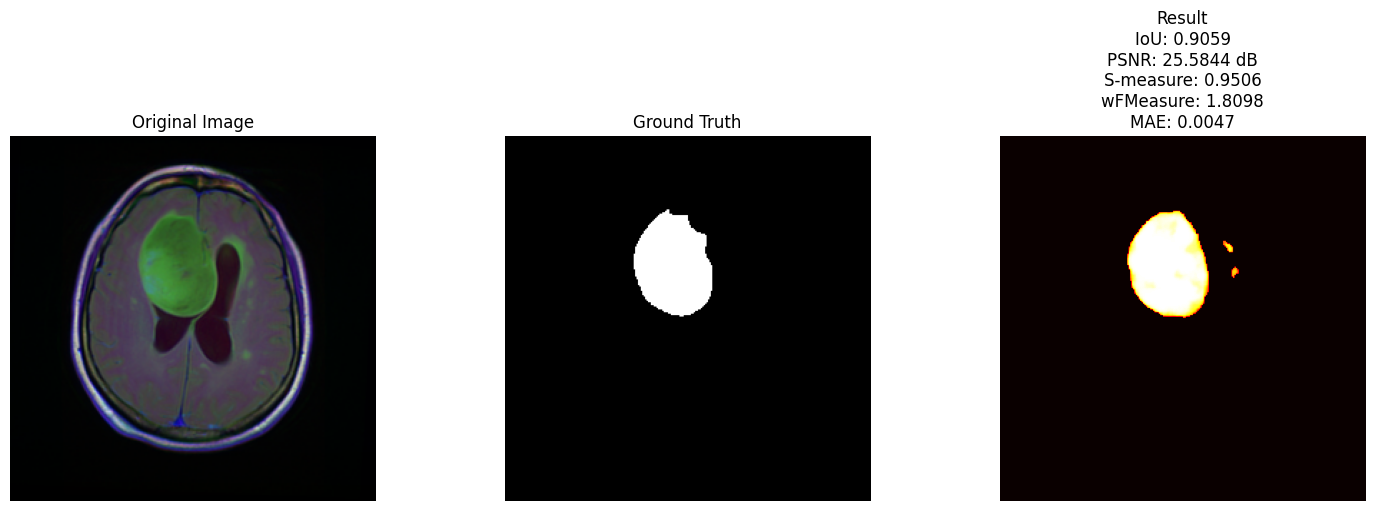

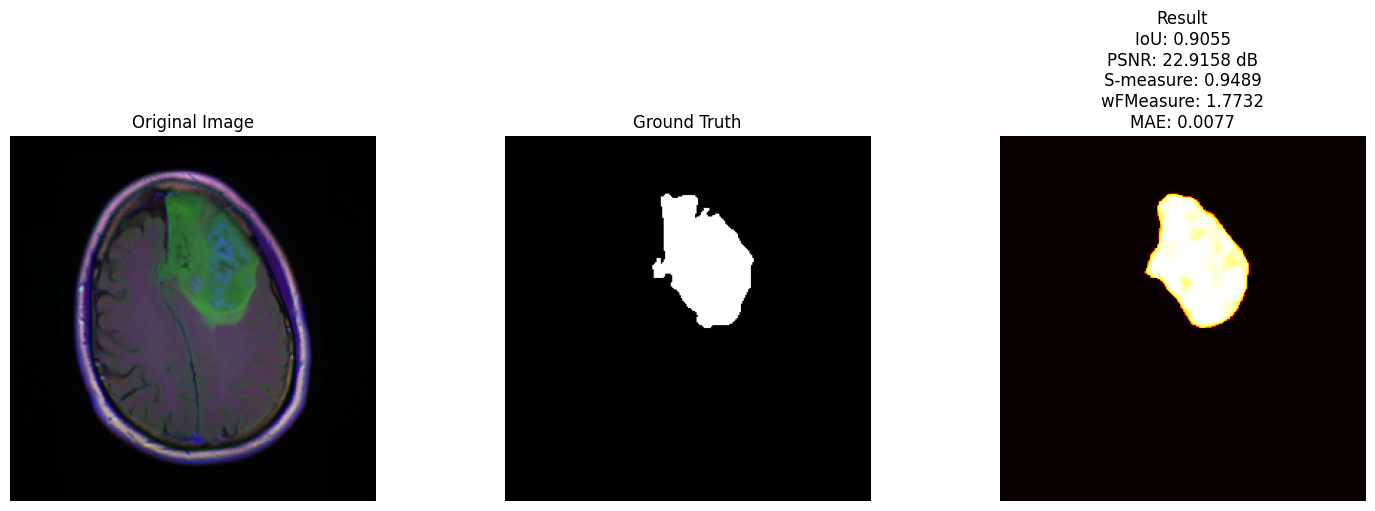

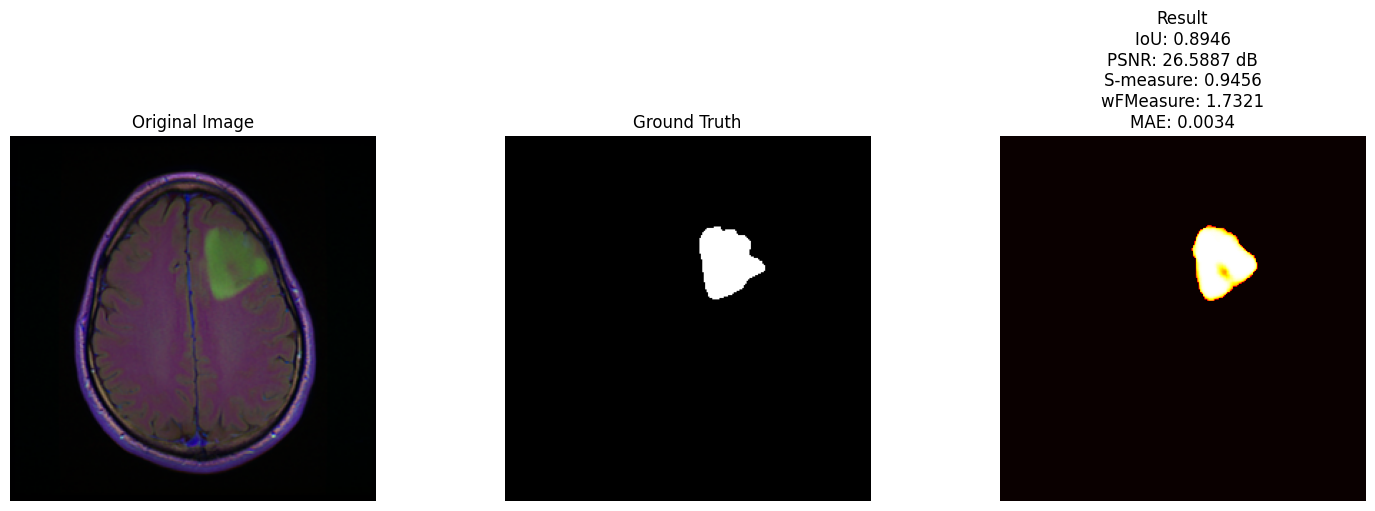

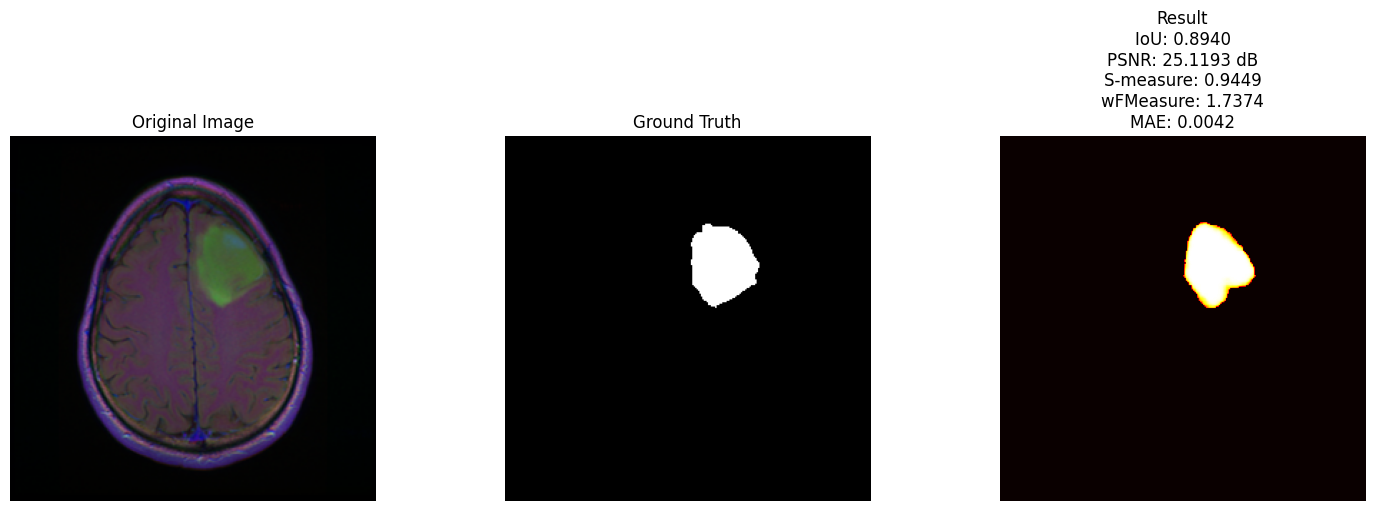

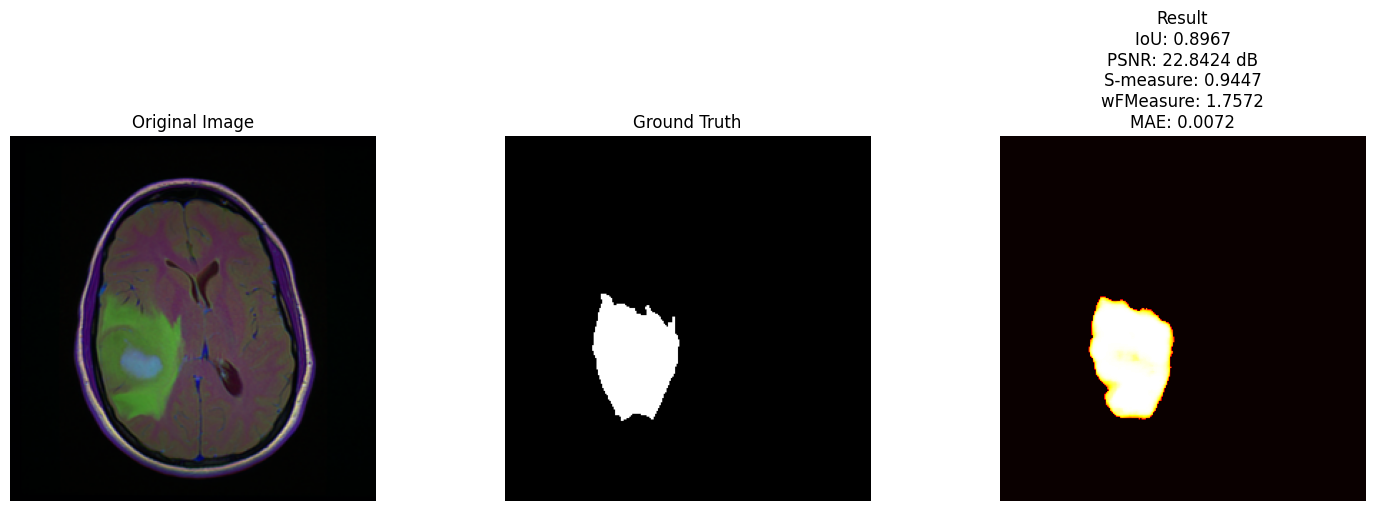

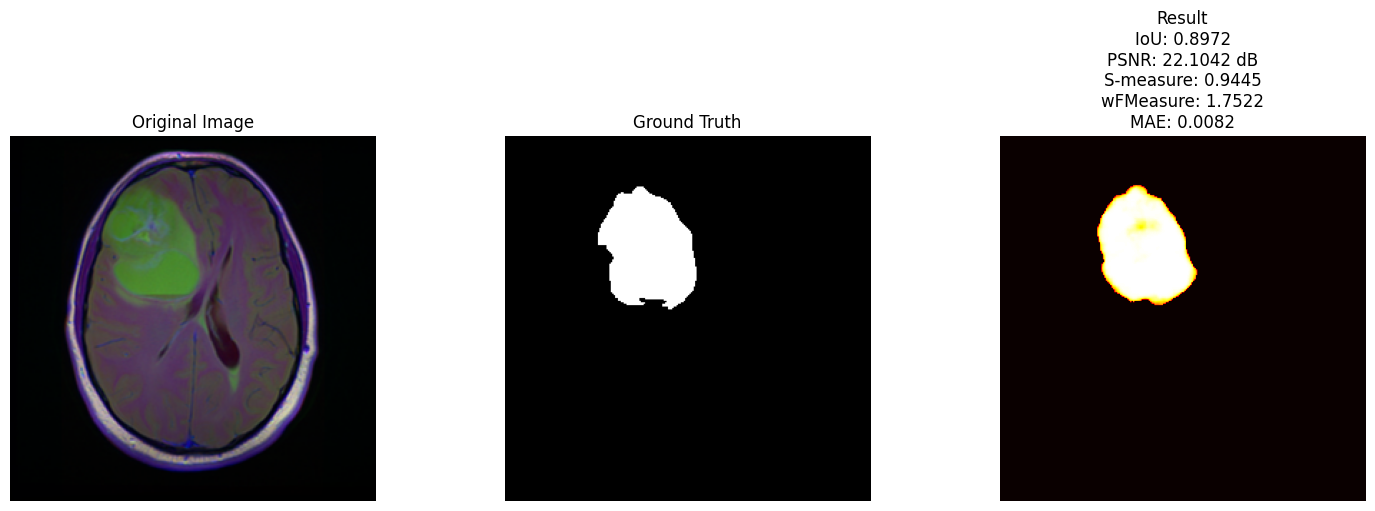

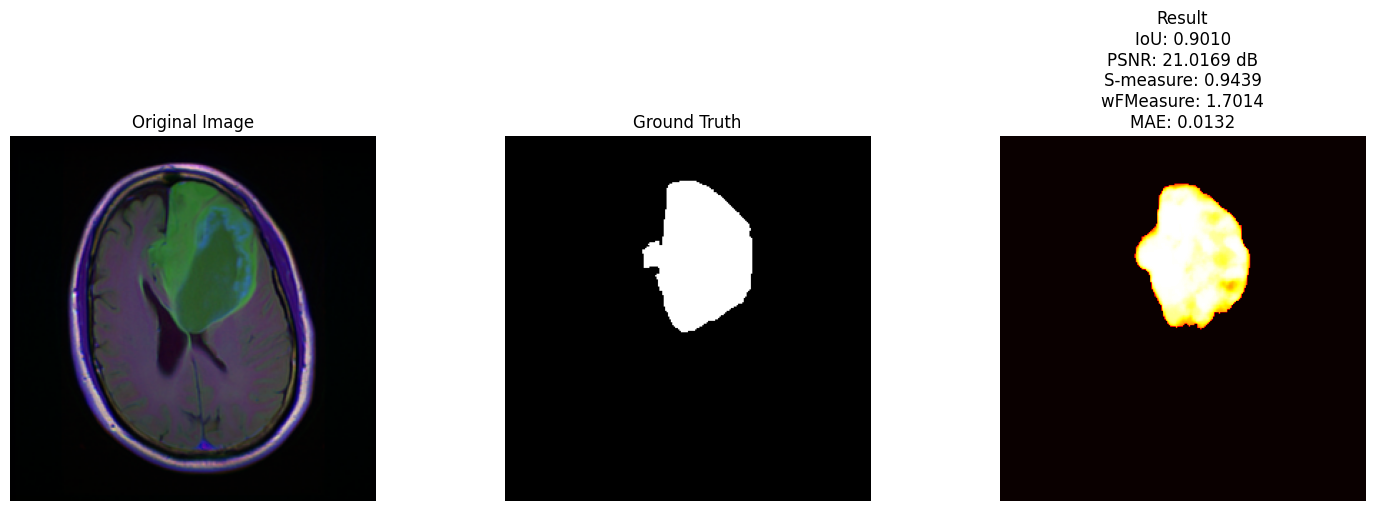

Average IoU: 0.4524
Average PSNR: 20.3634 dB
Average S-measure: 0.7185
Average Weighted F-measure: 0.8651
Average MAE: 0.0153
PDF with visualizations saved to: /content/drive/MyDrive/CamoDiffusion-main/visualizations/results_visualizations.pdf


In [11]:
# @title
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Function to calculate S-measure
def _object(pred, gt):
    fg = pred * gt
    bg = (1 - pred) * (1 - gt)
    u = np.mean(gt)

    if u == 0:
        return 1 - np.mean(pred)
    elif u == 1:
        return np.mean(pred)
    else:
        fg_score = np.sum(fg) / (np.sum(gt) + 1e-8)
        bg_score = np.sum(bg) / (np.sum(1 - gt) + 1e-8)
        return u * fg_score + (1 - u) * bg_score

def _region(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / (union + 1e-8)

def calculate_smeasure(gt, pred):
    gt_binary = (gt > 128).astype(np.uint8)  # Binarize GT
    pred_normalized = pred / 255.0  # Normalize Prediction

    alpha = 0.5
    sm = alpha * _object(pred_normalized, gt_binary) + (1 - alpha) * _region(pred_normalized, gt_binary)
    return sm

# Function to calculate PSNR
def calculate_psnr(gt, pred):
    mse = np.mean((gt.astype(np.float32) - pred.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match

    pixel_max = 255.0
    psnr = 20 * np.log10(pixel_max / np.sqrt(mse))
    return psnr

# Compute Weighted F-measure (wFMeasure)
def calculate_wfmeasure(gt, pred):
    gt_binary = (gt > 128).astype(np.uint8)
    pred_normalized = pred / 255.0
    true_positive = np.sum(pred_normalized * gt_binary)
    false_positive = np.sum(pred_normalized * (1 - gt_binary))
    false_negative = np.sum((1 - pred_normalized) * gt_binary)
    denominator = true_positive + false_positive + false_negative + 1e-8

    wfm = (2 * true_positive) / denominator
    return wfm

# Compute IoU
def compute_iou(gt, pred):
    intersection = np.logical_and(gt > 0, pred > 0).sum()
    union = np.logical_or(gt > 0, pred > 0).sum()
    return intersection / union if union > 0 else 0.0

# Compute MAE (Mean Absolute Error)
def calculate_mae(gt, pred):
    gt_normalized = gt / 255.0
    pred_normalized = pred / 255.0
    mae = np.mean(np.abs(gt_normalized - pred_normalized))
    return mae

# Paths
image_folder = "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_Imgs"
gt_folder = "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT"
result_folder = "/content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI"
save_folder = "/content/drive/MyDrive/CamoDiffusion-main/visualizations"
os.makedirs(save_folder, exist_ok=True)

# Metrics and Visualization
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
results_evaluation = []

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    gt_path = os.path.join(gt_folder, image_file.replace(".png", "_mask.png"))
    result_path = os.path.join(result_folder, image_file)

    try:
        # Load images
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)

        if gt is not None and result is not None:
            # Compute metrics
            iou = compute_iou(gt, result)
            psnr = calculate_psnr(gt, result)
            sm = calculate_smeasure(gt, result)
            wfm = calculate_wfmeasure(gt, result)
            mae = calculate_mae(gt, result)
            non_black_pixels = (result > 0).sum()

            # Append metrics
            results_evaluation.append((image_file, iou, psnr, sm, wfm, mae, non_black_pixels))
    except Exception as e:
        print(f"Error processing {image_file}: {e}")

# Sort by S-measure and IoU
sorted_results = sorted(results_evaluation, key=lambda x: (x[3], x[1]), reverse=True)

# Save visualizations to a PDF and show in output
pdf_path = os.path.join(save_folder, "results_visualizations.pdf")
with PdfPages(pdf_path) as pdf:
    top_n = 15  # Number of top results to visualize
    for image_file, iou, psnr, sm, wfm, mae, non_black_pixels in sorted_results[:top_n]:
        # Load original, GT, and result
        image_path = os.path.join(image_folder, image_file)
        gt_path = os.path.join(gt_folder, image_file.replace(".png", "_mask.png"))
        result_path = os.path.join(result_folder, image_file)

        image = cv2.imread(image_path)  # Original
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)  # Ground truth
        result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)  # Prediction

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(gt, cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        axes[2].imshow(result, cmap='hot')
        axes[2].set_title(
            f"Result\nIoU: {iou:.4f}\nPSNR: {psnr:.4f} dB\nS-measure: {sm:.4f}\nwFMeasure: {wfm:.4f}\nMAE: {mae:.4f}"
        )
        axes[2].axis("off")

        plt.tight_layout()
        pdf.savefig(fig)  # Save to PDF
        plt.show()  # Show in output console
        plt.close(fig)

# Print final average metrics
average_iou = np.mean([x[1] for x in results_evaluation])
average_psnr = np.mean([x[2] for x in results_evaluation])
average_smeasure = np.mean([x[3] for x in results_evaluation])
average_wfmeasure = np.mean([x[4] for x in results_evaluation])
average_mae = np.mean([x[5] for x in results_evaluation])

print(f"Average IoU: {average_iou:.4f}")
print(f"Average PSNR: {average_psnr:.4f} dB")
print(f"Average S-measure: {average_smeasure:.4f}")
print(f"Average Weighted F-measure: {average_wfmeasure:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"PDF with visualizations saved to: {pdf_path}")


6. Maintanence - prepare folders for next run

In [12]:
# @title
import os

def process_directory(directory, delete_files=False):
    """
    Deletes all files in the specified directory and counts the remaining files.

    Parameters:
        directory (str): Path to the directory to process.
        delete_files (bool): Whether to delete all files in the directory first.

    Returns:
        int: Number of files in the directory after deletion (if any).
    """
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return 0

    # Optionally delete files
    if delete_files:
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")
        print(f"All files deleted in directory: {directory}")

    # Count remaining files in the directory
    file_count = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
    return file_count

# Directories to process
directories = [
    "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT",
    "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_Imgs",
    "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_GT",
    "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_Imgs",
    "/content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI",
]

# Clear the results directory first
results_dir = "/content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI"
process_directory(results_dir, delete_files=True)

# Count and display the number of files in each directory after deletion
for dir_path in directories:
    file_count = process_directory(dir_path, delete_files=False)
    print(f"Directory: {dir_path}, File Count: {file_count}")


All files deleted in directory: /content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI
Directory: /content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT, File Count: 404
Directory: /content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_Imgs, File Count: 404
Directory: /content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_GT, File Count: 961
Directory: /content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_Imgs, File Count: 961
Directory: /content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI, File Count: 0
